<a href="https://colab.research.google.com/github/punnarat-w/Yomriver_analysis/blob/main/ForecastingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Retrieving Data

In [122]:
# importing pandas library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [123]:
# download description file
!gdown --id 1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f

Downloading...
From: https://drive.google.com/uc?id=1GJdM5L1SH1Cs95xFeflf3HT7kLT4wd-f
To: /content/st.csv
100% 20.8k/20.8k [00:00<00:00, 16.4MB/s]


In [124]:
def getData(filename):
  data = pd.read_csv(filename)
  # data['Datetime'] = pd.to_datetime(data['Datetime'])
  # data = data.set_index('Datetime')
  return data

In [125]:
description = getData('st.csv')
description

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
0,BDLH,ทต.ลานหอย,17.008562,99.582995,ลานหอย,บ้านด่านลานหอย,สุโขทัย,ภาคเหนือ,R,NaN
1,SAMN,ทต.สามง่าม,16.512774,100.208275,สามง่าม,สามง่าม,พิจิตร,ภาคเหนือ,R,NaN
2,SNGT,อบต.บ้านกลาง,18.482018,100.177530,บ้านกลาง,สอง,แพร่,ภาคเหนือ,R,NaN
3,KPPT,อบจ.กำแพงเพชร,16.410858,99.521990,อ่างทอง,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
4,PKTI,ทต.พรานกระต่าย,16.653760,99.575782,พรานกระต่าย,พรานกระต่าย,กำแพงเพชร,ภาคเหนือ,R,NaN
...,...,...,...,...,...,...,...,...,...,...
109,VLGE13,ชุมแสงสงคราม,16.858560,100.059642,ชุมแสงสงคราม,บางระกำ,พิษณุโลก,ภาคเหนือ,W,NaN
110,VLGE15,ชุมชนหนองปิ้งไก่,16.434798,99.367315,นาบ่อคำ,เมืองกำแพงเพชร,กำแพงเพชร,ภาคเหนือ,R,NaN
111,VLGE12,นครป่าหมาก,16.623374,100.369210,นครป่าหมาก,บางกระทุ่ม,พิษณุโลก,ภาคเหนือ,W,NaN
112,TBW014,สะพานข้ามคลองเกรียงไกร,15.843182,100.211475,บางเคียน,ชุมแสง,นครสวรรค์,ภาคเหนือ,W,NaN


In [126]:
description['region'].value_counts()

R    77
W    37
Name: region, dtype: int64

Finding the code of chosen stations

In [127]:
description[description['name'] == 'ทต.เชียงม่วน']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
32,CGMN,ทต.เชียงม่วน,18.893837,100.28784,เชียงม่วน,เชียงม่วน,พะเยา,ภาคเหนือ,R,NaN


In [128]:
description[description['name'] == 'อบต.วังชิ้น']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
25,WCHN,อบต.วังชิ้น,17.87883,99.61927,วังชิ้น,วังชิ้น,แพร่,ภาคเหนือ,R,NaN


In [129]:
description[description['name'] == 'โรงฆ่าสัตว์ ทม.สวรรคโลก']

,code,name,lat,long,tambon,amphoe,province,basin,region,station_type
17,SWKL,โรงฆ่าสัตว์ ทม.สวรรคโลก,17.31681,99.825146,เมืองสวรรคโลก,สวรรคโลก,สุโขทัย,ภาคเหนือ,R,NaN


## **มิล**

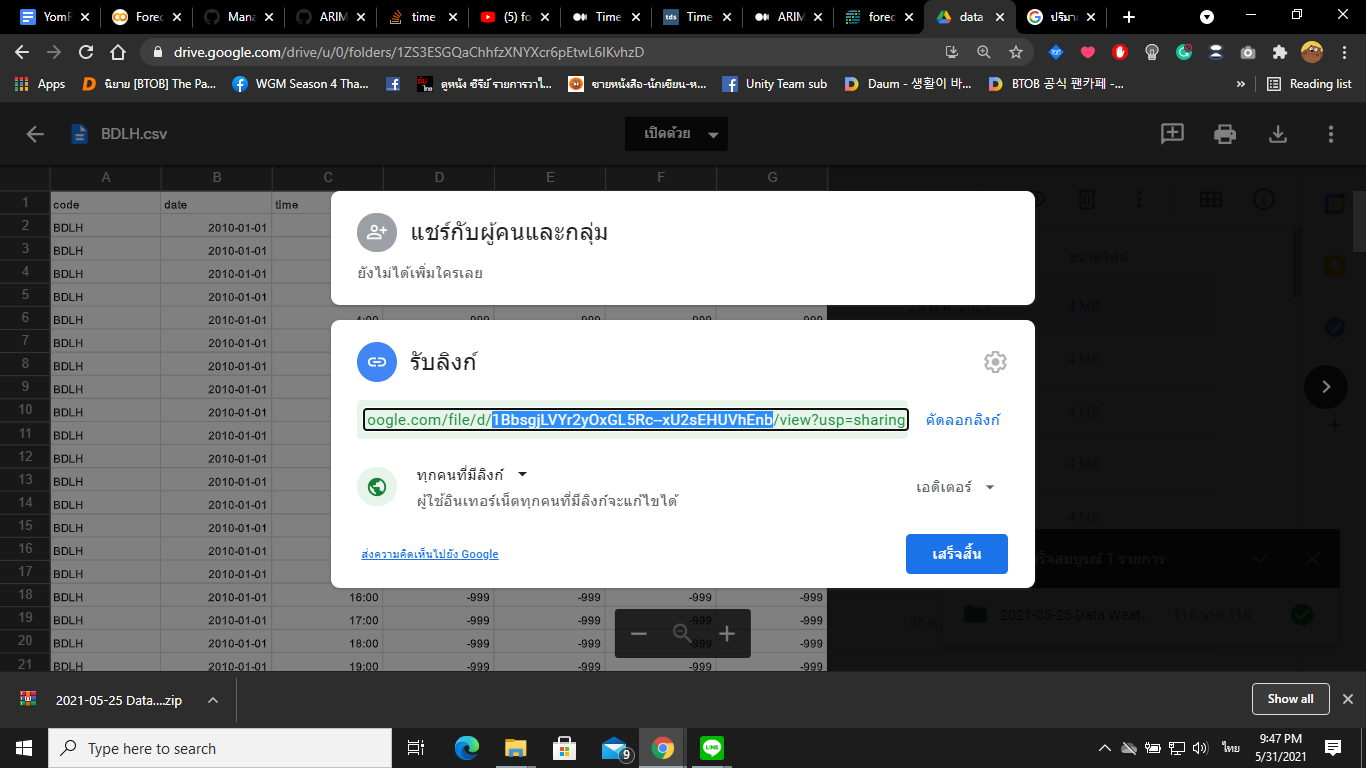

ดูรหัสสถานีจากข้างบนแล้วเปิดแชร์ไฟล์แล้วก็อปตามรูปมาใส่หลัง --id ข้างล่าง

In [130]:
# download station file
!gdown --id 1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
!gdown --id 1dj14nux3FyViM9heQwHxio1QZleZoZJx
!gdown --id 1hT_L86beygC_OQ1jMushxeDga8ZBM9Js

Downloading...
From: https://drive.google.com/uc?id=1ebJddYtRmEJbU9ITdvObE0IGr2zz5K0f
To: /content/CGMN.csv
3.72MB [00:00, 57.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dj14nux3FyViM9heQwHxio1QZleZoZJx
To: /content/WCHN.csv
3.65MB [00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hT_L86beygC_OQ1jMushxeDga8ZBM9Js
To: /content/SWKL.csv
3.69MB [00:00, 93.1MB/s]


In [203]:
north_df = getData('CGMN.csv')
mid_df = getData('WCHN.csv')
south_df = getData('SWKL.csv')

In [205]:
# north_df[north_df.date.str.contains('2012-07-12')]
north_df = north_df.drop(range(0,22167))

In [206]:
north_df

,code,date,time,rain1h,temp_out,press,humid
22167,CGMN,2012-07-12,15:00,0.0,34.3,973.0,70.0
22168,CGMN,2012-07-12,16:00,0.0,34.8,973.0,68.0
22169,CGMN,2012-07-12,17:00,0.0,36.3,971.0,64.0
22170,CGMN,2012-07-12,18:00,0.0,32.8,974.0,70.0
22171,CGMN,2012-07-12,19:00,0.0,30.9,975.0,71.0
...,...,...,...,...,...,...,...
96427,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4
96428,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0
96429,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5
96430,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9


In [208]:
# mid_df[mid_df.date.str.contains('2012-01-09')]
mid_df = mid_df.drop(range(0,17722))

In [209]:
mid_df

,code,date,time,rain1h,temp_out,press,humid
17722,WCHN,2012-01-09,10:00,0.0,27.0,1004.0,97.0
17723,WCHN,2012-01-09,11:00,0.0,31.9,1003.0,69.0
17724,WCHN,2012-01-09,12:00,0.0,34.8,1002.0,51.0
17725,WCHN,2012-01-09,13:00,0.0,35.3,1001.0,53.0
17726,WCHN,2012-01-09,14:00,0.0,35.8,1000.0,48.0
...,...,...,...,...,...,...,...
96427,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9
96428,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4
96429,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5
96430,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0


In [212]:
# south_df[south_df.date.str.contains('2011-09-29')]
south_df = south_df.drop(range(0,15280))

In [213]:
south_df

,code,date,time,rain1h,temp_out,press,humid
15280,SWKL,2011-09-29,16:00,0.0,35.8,995.0,71.0
15281,SWKL,2011-09-29,17:00,0.0,33.8,997.0,76.0
15282,SWKL,2011-09-29,18:00,0.0,30.4,999.0,84.0
15283,SWKL,2011-09-29,19:00,0.0,29.4,1000.0,91.0
15284,SWKL,2011-09-29,20:00,0.0,28.4,1001.0,97.0
...,...,...,...,...,...,...,...
96427,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3
96428,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8
96429,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0
96430,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2


In [214]:
# insert column key in north_df for merge data
n_10 = north_df[north_df.date.str.contains('2010')]
n_10.insert(0, "Key", "10")
n_11 = north_df[north_df.date.str.contains('2011')]
n_11.insert(0, "Key", "11")
n_12 = north_df[north_df.date.str.contains('2012')]
n_12.insert(0, "Key", "12")
n_13 = north_df[north_df.date.str.contains('2013')]
n_13.insert(0, "Key", "13")
n_14 = north_df[north_df.date.str.contains('2014')]
n_14.insert(0, "Key", "14")
n_15 = north_df[north_df.date.str.contains('2015')]
n_15.insert(0, "Key", "15")
n_16 = north_df[north_df.date.str.contains('2016')]
n_16.insert(0, "Key", "16")
n_17 = north_df[north_df.date.str.contains('2017')]
n_17.insert(0, "Key", "17")
n_18 = north_df[north_df.date.str.contains('2018')]
n_18.insert(0, "Key", "18")
n_19 = north_df[north_df.date.str.contains('2019')]
n_19.insert(0, "Key", "19")
n_20 = north_df[north_df.date.str.contains('2020')]
n_20.insert(0, "Key", "20")

In [215]:
# insert column key in mid_df for merge data
m_10 = mid_df[mid_df.date.str.contains('2010')]
m_10.insert(0, "Key", "10")
m_11 = mid_df[mid_df.date.str.contains('2011')]
m_11.insert(0, "Key", "11")
m_12 = mid_df[mid_df.date.str.contains('2012')]
m_12.insert(0, "Key", "12")
m_13 = mid_df[mid_df.date.str.contains('2013')]
m_13.insert(0, "Key", "13")
m_14 = mid_df[mid_df.date.str.contains('2014')]
m_14.insert(0, "Key", "14")
m_15 = mid_df[mid_df.date.str.contains('2015')]
m_15.insert(0, "Key", "15")
m_16 = mid_df[mid_df.date.str.contains('2016')]
m_16.insert(0, "Key", "16")
m_17 = mid_df[mid_df.date.str.contains('2017')]
m_17.insert(0, "Key", "17")
m_18 = mid_df[mid_df.date.str.contains('2018')]
m_18.insert(0, "Key", "18")
m_19 = mid_df[mid_df.date.str.contains('2019')]
m_19.insert(0, "Key", "19")
m_20 = mid_df[mid_df.date.str.contains('2020')]
m_20.insert(0, "Key", "20")

In [216]:
# insert column key in south_df for merge data
s_10 = south_df[south_df.date.str.contains('2010')]
s_10.insert(0, "Key", "10")
s_11 = south_df[south_df.date.str.contains('2011')]
s_11.insert(0, "Key", "11")
s_12 = south_df[south_df.date.str.contains('2012')]
s_12.insert(0, "Key", "12")
s_13 = south_df[south_df.date.str.contains('2013')]
s_13.insert(0, "Key", "13")
s_14 = south_df[south_df.date.str.contains('2014')]
s_14.insert(0, "Key", "14")
s_15 = south_df[south_df.date.str.contains('2015')]
s_15.insert(0, "Key", "15")
s_16 = south_df[south_df.date.str.contains('2016')]
s_16.insert(0, "Key", "16")
s_17 = south_df[south_df.date.str.contains('2017')]
s_17.insert(0, "Key", "17")
s_18 = south_df[south_df.date.str.contains('2018')]
s_18.insert(0, "Key", "18")
s_19 = south_df[south_df.date.str.contains('2019')]
s_19.insert(0, "Key", "19")
s_20 = south_df[south_df.date.str.contains('2020')]
s_20.insert(0, "Key", "20")

In [219]:
# result nf_df, mf_df amd sf_df
north_df = pd.concat([n_10, n_11, n_12, n_13, n_14, n_15, n_16, n_17, n_18, n_19, n_20], sort=False)
mid_df = pd.concat([m_10, m_11, m_12, m_13, m_14, m_15, m_16, m_17, m_18, m_19, m_20], sort=False)
south_df = pd.concat([s_10, s_11, s_12, s_13, s_14, s_15, s_16, s_17, s_18, s_19, s_20], sort=False)
# display(north_df)
# display(mid_df)
# display(south_df)

In [220]:
# download storm file
!gdown --id 1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L

Downloading...
From: https://drive.google.com/uc?id=1Sj-7RPCg6Ul4CWFdZ-hLAiWpVCzf-2_L
To: /content/Storm_2010-2020.csv
100% 17.8k/17.8k [00:00<00:00, 25.4MB/s]


In [221]:
storm_df = getData('Storm_2010-2020.csv')
# storm_df

In [222]:
# download forest file
!gdown --id 1AYwTBFuIVJJ0QGDu1lALIQDmwpIKNO8P

Downloading...
From: https://drive.google.com/uc?id=1AYwTBFuIVJJ0QGDu1lALIQDmwpIKNO8P
To: /content/ForestNorth_2013-2019.csv
100% 1.57k/1.57k [00:00<00:00, 1.34MB/s]


In [223]:
forest_df = getData('ForestNorth_2013-2019.csv')
# forest_df

In [224]:
nf_df = forest_df[forest_df['Province'] == 'ตอนบน']
mf_df = forest_df[forest_df['Province'] == 'ตอนกลาง']
sf_df = forest_df[forest_df['Province'] == 'ตอนล่าง']
nf_df = nf_df.astype(str)
mf_df = mf_df.astype(str)
sf_df = sf_df.astype(str)
# display(nf_df)
# display(mf_df)
# display(sf_df)

In [225]:
# insert column key in nf_df for merge data
nf_10 = nf_df[nf_df['Year'] == '2010']
nf_10.insert(0, "Key", "10")
nf_11 = nf_df[nf_df['Year'] == '2011']
nf_11.insert(0, "Key", "11")
nf_12 = nf_df[nf_df['Year'] == '2012']
nf_12.insert(0, "Key", "12")
nf_13 = nf_df[nf_df['Year'] == '2013']
nf_13.insert(0, "Key", "13")
nf_14 = nf_df[nf_df['Year'] == '2014']
nf_14.insert(0, "Key", "14")
nf_15 = nf_df[nf_df['Year'] == '2015']
nf_15.insert(0, "Key", "15")
nf_16 = nf_df[nf_df['Year'] == '2016']
nf_16.insert(0, "Key", "16")
nf_17 = nf_df[nf_df['Year'] == '2017']
nf_17.insert(0, "Key", "17")
nf_18 = nf_df[nf_df['Year'] == '2018']
nf_18.insert(0, "Key", "18")
nf_19 = nf_df[nf_df['Year'] == '2019']
nf_19.insert(0, "Key", "19")
nf_20 = nf_df[nf_df['Year'] == '2020']
nf_20.insert(0, "Key", "20")

In [226]:
# insert column key in mf_df for merge data
mf_10 = mf_df[mf_df['Year'] == '2010']
mf_10.insert(0, "Key", "10")
mf_11 = mf_df[mf_df['Year'] == '2011']
mf_11.insert(0, "Key", "11")
mf_12 = mf_df[mf_df['Year'] == '2012']
mf_12.insert(0, "Key", "12")
mf_13 = mf_df[mf_df['Year'] == '2013']
mf_13.insert(0, "Key", "13")
mf_14 = mf_df[mf_df['Year'] == '2014']
mf_14.insert(0, "Key", "14")
mf_15 = mf_df[mf_df['Year'] == '2015']
mf_15.insert(0, "Key", "15")
mf_16 = mf_df[mf_df['Year'] == '2016']
mf_16.insert(0, "Key", "16")
mf_17 = mf_df[mf_df['Year'] == '2017']
mf_17.insert(0, "Key", "17")
mf_18 = mf_df[mf_df['Year'] == '2018']
mf_18.insert(0, "Key", "18")
mf_19 = mf_df[mf_df['Year'] == '2019']
mf_19.insert(0, "Key", "19")
mf_20 = mf_df[mf_df['Year'] == '2020']
mf_20.insert(0, "Key", "20")

In [227]:
# insert column key in sf_df for merge data
sf_10 = sf_df[sf_df['Year'] == '2010']
sf_10.insert(0, "Key", "10")
sf_11 = sf_df[sf_df['Year'] == '2011']
sf_11.insert(0, "Key", "11")
sf_12 = sf_df[sf_df['Year'] == '2012']
sf_12.insert(0, "Key", "12")
sf_13 = sf_df[sf_df['Year'] == '2013']
sf_13.insert(0, "Key", "13")
sf_14 = sf_df[sf_df['Year'] == '2014']
sf_14.insert(0, "Key", "14")
sf_15 = sf_df[sf_df['Year'] == '2015']
sf_15.insert(0, "Key", "15")
sf_16 = sf_df[sf_df['Year'] == '2016']
sf_16.insert(0, "Key", "16")
sf_17 = sf_df[sf_df['Year'] == '2017']
sf_17.insert(0, "Key", "17")
sf_18 = sf_df[sf_df['Year'] == '2018']
sf_18.insert(0, "Key", "18")
sf_19 = sf_df[sf_df['Year'] == '2019']
sf_19.insert(0, "Key", "19")
sf_20 = sf_df[sf_df['Year'] == '2020']
sf_20.insert(0, "Key", "20")

In [230]:
# result nf_df, mf_df amd sf_df
nf_df = pd.concat([nf_10, nf_11, nf_12, nf_13, nf_14, nf_15, nf_16, nf_17, nf_18, nf_19, nf_20], sort=False)
mf_df = pd.concat([mf_10, mf_11, mf_12, mf_13, mf_14, mf_15, mf_16, mf_17, mf_18, mf_19, mf_20], sort=False)
sf_df = pd.concat([sf_10, sf_11, sf_12, sf_13, sf_14, sf_15, sf_16, sf_17, sf_18, sf_19, sf_20], sort=False)
# display(nf_df)
# display(mf_df)
# display(sf_df)

In [238]:
data_north = pd.merge(north_df, nf_df, on="Key", how="outer")
data_mid = pd.merge(mid_df, mf_df, on="Key", how="outer")
data_south = pd.merge(south_df, sf_df, on="Key", how="outer")
# display(data_north)
# display(data_mid)
# display(data_south)

In [ ]:
#Load ข้อมูลพายุ, พื้นที่ป่าไม้ แล้วเพิ่มไปในตารางแยกเป็นตอนบน ตอนกลาง ตอนล่าง

##Data Preparation



*   Data Cleansing



In [232]:
#overview data
print("สถานีทต.เชียงม่วน")
display(data_north)
print("\n\nสถานีอบต.วังชิ้น")
display(data_mid)
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(data_south)

สถานีทต.เชียงม่วน


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,12,CGMN,2012-07-12,15:00,0.0,34.3,973.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN
1,12,CGMN,2012-07-12,16:00,0.0,34.8,973.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
2,12,CGMN,2012-07-12,17:00,0.0,36.3,971.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN
3,12,CGMN,2012-07-12,18:00,0.0,32.8,974.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN
4,12,CGMN,2012-07-12,19:00,0.0,30.9,975.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74260,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,NaN,NaN,NaN,NaN,NaN,NaN
74261,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,NaN,NaN,NaN,NaN,NaN,NaN
74262,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,NaN,NaN,NaN,NaN,NaN,NaN
74263,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,NaN,NaN,NaN,NaN,NaN,NaN




สถานีอบต.วังชิ้น


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,12,WCHN,2012-01-09,10:00,0.0,27.0,1004.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN
1,12,WCHN,2012-01-09,11:00,0.0,31.9,1003.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN
2,12,WCHN,2012-01-09,12:00,0.0,34.8,1002.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
3,12,WCHN,2012-01-09,13:00,0.0,35.3,1001.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN
4,12,WCHN,2012-01-09,14:00,0.0,35.8,1000.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78705,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,NaN,NaN,NaN,NaN,NaN,NaN
78706,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,NaN,NaN,NaN,NaN,NaN,NaN
78707,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,NaN,NaN,NaN,NaN,NaN,NaN
78708,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,NaN,NaN,NaN,NaN,NaN,NaN




สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,11,SWKL,2011-09-29,16:00,0.0,35.8,995.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN
1,11,SWKL,2011-09-29,17:00,0.0,33.8,997.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN
2,11,SWKL,2011-09-29,18:00,0.0,30.4,999.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN
3,11,SWKL,2011-09-29,19:00,0.0,29.4,1000.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN
4,11,SWKL,2011-09-29,20:00,0.0,28.4,1001.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81147,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,NaN,NaN,NaN,NaN,NaN,NaN
81148,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,NaN,NaN,NaN,NaN,NaN,NaN
81149,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,NaN,NaN,NaN,NaN,NaN,NaN
81150,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
data_north = data_north.replace({-999: np.nan})
data_mid = data_mid.replace({-999: np.nan})
data_south = data_south.replace({-999: np.nan})
# display(data_north)
# display(data_mid)
# display(data_south)

Find missing value

In [234]:
#North
print("สถานีทต.เชียงม่วน")
display(data_north.isna().sum())
#Mid
print("\n\nสถานีอบต.วังชิ้น")
display(data_mid.isna().sum())
#South
print("\n\nสถานีโรงฆ่าสัตว์ ทม.สวรรคโลก")
display(data_south.isna().sum())

สถานีทต.เชียงม่วน


Key                             0
code                            0
date                            0
time                            0
rain1h                      12281
temp_out                    13675
press                       12584
humid                       20472
Year                        12921
Province                    12921
Province_Area               12921
Forest_Area                 12921
Percent_of_Province_Area    12921
Non_Forest_Area             12921
dtype: int64



สถานีอบต.วังชิ้น


Key                             0
code                            0
date                            0
time                            0
rain1h                       1285
temp_out                     2659
press                        1986
humid                       20952
Year                        17366
Province                    17366
Province_Area               17366
Forest_Area                 17366
Percent_of_Province_Area    17366
Non_Forest_Area             17366
dtype: int64



สถานีโรงฆ่าสัตว์ ทม.สวรรคโลก


Key                             0
code                            0
date                            0
time                            0
rain1h                       1504
temp_out                     2183
press                       23075
humid                        3205
Year                        19808
Province                    19808
Province_Area               19808
Forest_Area                 19808
Percent_of_Province_Area    19808
Non_Forest_Area             19808
dtype: int64

In [235]:
#fill by random values in their columns --ต้องดูก่อนว่าหายเยอะมั้ย
def fill_missing_value(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df[i].isna()
    random_feat = np.random.choice(df[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df.loc[nan_rows,i] = random_feat
  return df

In [239]:
north = fill_missing_value(data_north)
mid = fill_missing_value(data_mid)
south = fill_missing_value(data_south)
display(north)
display(mid)
display(south)

,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,12,CGMN,2012-07-12,15:00,0.0,34.3,973.0,70.0,2013,ตอนบน,"19,254,452.30","12,181,835.00",183.95,116.05
1,12,CGMN,2012-07-12,16:00,0.0,34.8,973.0,68.0,2017,ตอนบน,"19,254,452.30","12,115,729.16",182.92,117.08
2,12,CGMN,2012-07-12,17:00,0.0,36.3,971.0,64.0,2017,ตอนบน,"19,254,452.30","12,115,729.16",182.92,117.08
3,12,CGMN,2012-07-12,18:00,0.0,32.8,974.0,70.0,2018,ตอนบน,"19,254,452.30","12,128,810.16",183.14,116.86
4,12,CGMN,2012-07-12,19:00,0.0,30.9,975.0,71.0,2018,ตอนบน,"19,254,452.30","12,128,810.16",183.14,116.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74260,20,CGMN,2020-12-31,19:00,0.0,24.8,981.8,61.4,2015,ตอนบน,"19,254,452.30","12,177,345.86",183.97,116.03
74261,20,CGMN,2020-12-31,20:00,0.0,23.8,982.7,64.0,2017,ตอนบน,"19,254,452.30","12,115,729.16",182.92,117.08
74262,20,CGMN,2020-12-31,21:00,0.0,23.2,983.6,63.5,2018,ตอนบน,"19,254,452.30","12,128,810.16",183.14,116.86
74263,20,CGMN,2020-12-31,22:00,0.0,22.7,983.9,64.9,2014,ตอนบน,"19,254,452.30","12,197,151.71",184.23,115.77


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,12,WCHN,2012-01-09,10:00,0.0,27.0,1004.0,97.0,2013,ตอนกลาง,"4,051,912.64","2,515,083.57",62.07,37.93
1,12,WCHN,2012-01-09,11:00,0.0,31.9,1003.0,69.0,2017,ตอนกลาง,"4,051,912.64","2,610,863.30",64.44,35.56
2,12,WCHN,2012-01-09,12:00,0.0,34.8,1002.0,51.0,2017,ตอนกลาง,"4,051,912.64","2,610,863.30",64.44,35.56
3,12,WCHN,2012-01-09,13:00,0.0,35.3,1001.0,53.0,2018,ตอนกลาง,"4,051,912.64","2,623,909.73",64.76,35.24
4,12,WCHN,2012-01-09,14:00,0.0,35.8,1000.0,48.0,2018,ตอนกลาง,"4,051,912.64","2,623,909.73",64.76,35.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78705,20,WCHN,2020-12-31,19:00,0.0,22.8,998.5,81.9,2017,ตอนกลาง,"4,051,912.64","2,610,863.30",64.44,35.56
78706,20,WCHN,2020-12-31,20:00,0.0,21.3,999.6,86.4,2018,ตอนกลาง,"4,051,912.64","2,623,909.73",64.76,35.24
78707,20,WCHN,2020-12-31,21:00,0.0,19.8,1000.3,89.5,2015,ตอนกลาง,"4,051,912.64","2,600,029.96",64.17,35.83
78708,20,WCHN,2020-12-31,22:00,0.0,18.6,1000.8,93.0,2016,ตอนกลาง,"4,051,912.64","2,603,324.70",64.25,35.75


,Key,code,date,time,rain1h,temp_out,press,humid,Year,Province,Province_Area,Forest_Area,Percent_of_Province_Area,Non_Forest_Area
0,11,SWKL,2011-09-29,16:00,0.0,35.8,995.0,71.0,2013,ตอนล่าง,"84,183,434.55","41,275,108.50",551.44,748.56
1,11,SWKL,2011-09-29,17:00,0.0,33.8,997.0,76.0,2017,ตอนล่าง,"84,183,434.55","41,652,816.09",564.0,736.0
2,11,SWKL,2011-09-29,18:00,0.0,30.4,999.0,84.0,2017,ตอนล่าง,"84,183,434.55","41,652,816.09",564.0,736.0
3,11,SWKL,2011-09-29,19:00,0.0,29.4,1000.0,91.0,2018,ตอนล่าง,"84,183,434.55","41,728,212.55",565.64,734.36
4,11,SWKL,2011-09-29,20:00,0.0,28.4,1001.0,97.0,2018,ตอนล่าง,"84,183,434.55","41,728,212.55",565.64,734.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81147,20,SWKL,2020-12-31,19:00,0.0,22.8,1008.1,61.3,2019,ตอนล่าง,"84,183,434.55","41,661,864.73",565.03,734.97
81148,20,SWKL,2020-12-31,20:00,0.0,22.7,1009.2,61.8,2016,ตอนล่าง,"84,183,434.55","41,652,712.94",563.8,736.2
81149,20,SWKL,2020-12-31,21:00,0.0,21.1,1010.1,66.0,2019,ตอนล่าง,"84,183,434.55","41,661,864.73",565.03,734.97
81150,20,SWKL,2020-12-31,22:00,0.0,19.8,1010.7,70.2,2014,ตอนล่าง,"84,183,434.55","41,746,553.35",565.14,734.86


## **จี้**


Check error data

In [ ]:
#สถานีตอนบน
#df['column'].describe() ดูค่าว่าเกินเกณฑ์มั้ย

In [ ]:
# df['column'].unique() ดูพวกวัน พวกที่เป็น category error

In [ ]:
#สถานีตอนกลาง

In [ ]:
#สถานีตอนล่าง



*   Preprocessing



In [ ]:
def change_todate(df):
  df['Year'] = df['date'].apply(lambda x: str(x)[:4])
  df['Month'] = df['date'].apply(lambda x: str(x)[5:7])
  df['Day'] = df['date'].apply(lambda x: str(x)[8:])
  df['date'] = pd.to_datetime(df['date'])
  return df

In [ ]:
#change_todate(df)

In [ ]:
#ตอนบน กลาง ล่าง



*   Transformation



In [ ]:
#ตอนบน กลาง ล่าง

In [ ]:
# transform all features to 1 day (ฝนสะสมต่อวัน, อุณหภูมิ ความกดอากาศ ความเร็วลมเฉลี่ย) groupby aggregate


In [ ]:
# add column จำนวนวันที่ฝนตก

In [ ]:
# set index
def transform_index(dataframe):
  dataframe = dataframe.set_index('date')
  return dataframe

In [ ]:
#เรียกใช้ transform_index

##Data Exploration

## **อิ่ม**

*   Analyzing and comparing rainfall <br> ดูปริมาณน้ำฝนแล้วก็แนวโน้มของปัจจัยอื่นๆด้วยได้ เพื่อตอบคำถาม plot graph<br> 
-ปริมาณฝนรายปีมีการเปลี่ยนแปลงอย่างไร<br> 
-บริเวณใด(บน กลาง ล่าง มีความผันผวน)ของปริมาณฝนมากที่สุด ระหว่างฤดูหรือปี<br> 


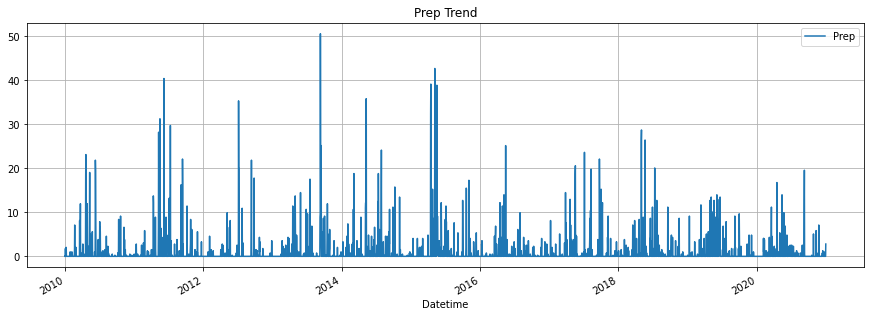

In [ ]:
#ตัวอย่าง plot แต่อย่าลืมทำเป็นปีก่อนจะดูง่ายกว่าภาพล่าง df_new = df.copy()

# df_new.Prep.plot(figsize=(15,5))
# plt.title('Prep Trend')
# #plt.title('Symbol: {}'.format(stock_symbol))
# plt.grid()
# plt.legend();

In [ ]:
#สถานีตอนบน

In [ ]:
#สถานีตอนกลาง

In [ ]:
#สถานีตอนล่าง



*   Season Time Series --มิ้ม



In [ ]:
# decompose trend, seasonal, and residual
from statsmodels.tsa.seasonal import seasonal_decompose

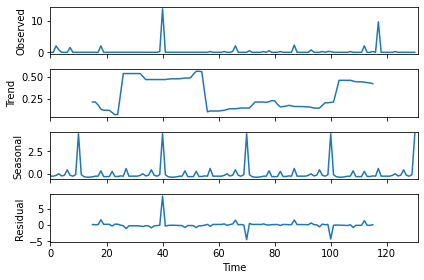

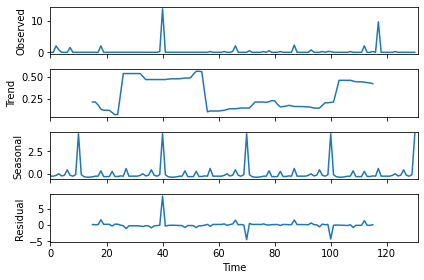

In [ ]:
# prep_decom = seasonal_decompose(df.Prep.values, model='additive', freq= 30)

# prep_decom.plot()

##Data Modeling

In [ ]:
# # Create get_X_y function to get dependent (y) and independent (X) variables
# def prep_data(dataframe):
  
#   dataframe['date'] = pd.to_datetime(dataframe['date'])
#   dataframe = dataframe.set_index('date')

#   # Extract time series variable
#   X = dataframe.reset_index()[['date']]
#   X['Year'] = [X.iloc[i, 0].year for i in range(len(X))]
#   X['Month'] = [X.iloc[i, 0].month for i in range(len(X))]
#   X['Day'] = [X.iloc[i, 0].day for i in range(len(X))]
#   #X['EnglishDay'] = X.Date.dt.strftime('%a')

#   # Set categorical variable
#   X = X.astype({'Month':'category', 
#                 'Day':'category'}).set_index('date')

#   # Get OHLC
#   X = X.merge(dataframe, left_index=True, right_index=True)

#   # Extract dependent variable
#   #y = dataframe[['Prep']].copy()

#   # col_drop = ['Station', 'MaxTemp', 'MaxTempTime', 'MinTemp', 'MinTempTime',
#   #                   'MaxRHTime', 'MinRHTime', 'SR', 'Prep', 'MaxSTemp5', 'MaxSTemp5Time', 'MinSTemp5', 'MinSTemp5Time',
#   #                   'MaxSTemp15', 'MaxSTemp15Time', 'MinSTemp15', 'MinSTemp15Time', 'BV','Year_y', 'MaxWGTime', 'DirectionMaxWG']
#   # X = X.drop(col_drop, axis=1)
#   #X = X.rename(columns={'Year_x' : 'Year'})
#   return X #, y

In [ ]:
X, y = get_X_y(data)
X.head()

,Year,Month,Day,AvgTemp,VP,MaxRH,MinRH,WR,MaxWG
Datetime,,,,,,,,,
2010-01-01,2010,1,1,-4.459,0.262,0.866,0.276,54.20,6.125
2010-01-02,2010,1,2,-1.732,0.335,0.938,0.300,124.00,8.970
2010-01-03,2010,1,3,-1.364,0.411,0.971,0.377,72.00,5.300
2010-01-04,2010,1,4,-5.664,0.338,0.959,0.441,41.20,3.725
2010-01-05,2010,1,5,-2.719,0.382,0.934,0.525,58.46,4.325


In [ ]:
def encoding_data(X, y):
  X_encoded = pd.get_dummies(X)
  y = pd.DataFrame(y, index= y.index, columns= ['Prep'])
  return X_encoded, y

In [ ]:
#Split data

def train_test_split(dataframe, y, trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  y_test = y.iloc[train_size:, :]


  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X_encoded, y, trainsize=0.8)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y = lr.predict(X_test)

In [ ]:
#Error
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test, y)
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

55.541302778105994


In [ ]:
def prediction_model(X_train, X_test, y_train, y_test):
  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error
  import math
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  
  MSE = mean_squared_error(y_test, y_pred)
  RMSE = math.sqrt(MSE)
  print("Root Mean Square Error:\n")
  print(RMSE)
  return y_pred

In [ ]:
#Visualize
def visualize(X, y, y_hat):

  # Set figure size
  plt.figure(figsize=(30, 10))

  # Plot actual price
  plt.plot(X.index, y, label='Actual Prep')

  # Plot predicted price
  plt.plot(X.index, y_hat, label='Predicted Prep')

  # Set title
  plt.title('Prep')

  # Set x-label
  plt.xlabel('Period')

  # Set y-label
  plt.ylabel('Prep')

  # Plot grid
  plt.grid()

  # Display legend
  plt.legend()

  # Display graph
  plt.show()

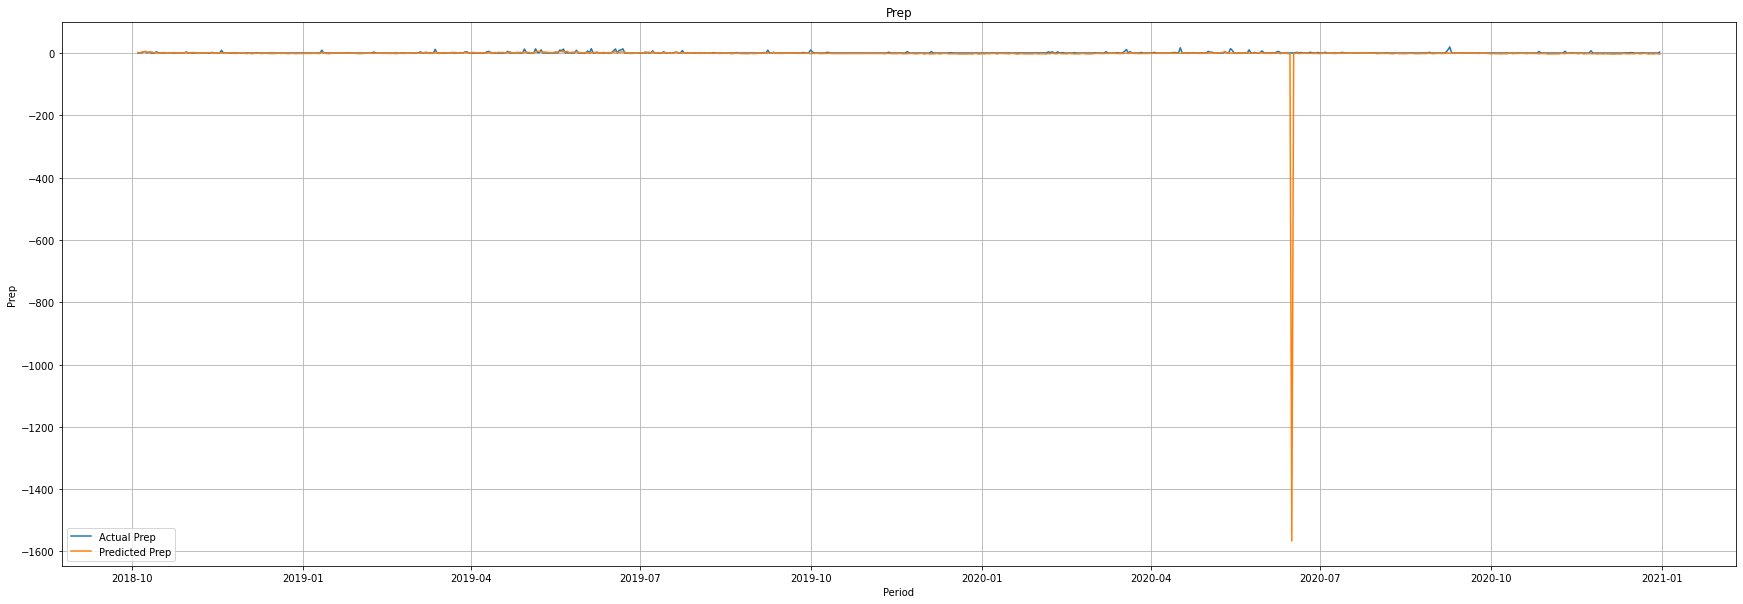

In [ ]:
visualize(X_test,y_test,y)

##Feature Engineering

In [ ]:
# Create feature_engineer function to extract new features
def feature_engineer(dataframe, feat_eng=False):

  if feat_eng:
    # Create a feature from previous day AvgTemp
    dataframe['PreviousDayAvgTemp'] = dataframe[['AvgTemp']].shift(periods=1,fill_value=0)

    # Create a feature from previous day VP
    dataframe['PreviousDayVP'] = dataframe[['VP']].shift(periods=1,fill_value=0)

    # Create a feature from previous day MaxRH
    dataframe['PreviousDayMaxRH'] = dataframe[['MaxRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MinRH
    dataframe['PreviousDayMinRH'] = dataframe[['MinRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day WR
    dataframe['PreviousDayWR'] = dataframe[['WR']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MaxWG
    dataframe['PreviousDayMaxWG'] = dataframe[['MaxWG']].shift(periods=1,fill_value=0)
 
  return dataframe

In [ ]:
# Test our feature_engineer function
X_engineered = feature_engineer(X, feat_eng=True)
X_engineered

,Year,Month,Day,AvgTemp,VP,MaxRH,MinRH,WR,MaxWG,PreviousDayAvgTemp,PreviousDayVP,PreviousDayMaxRH,PreviousDayMinRH,PreviousDayWR,PreviousDayMaxWG
Datetime,,,,,,,,,,,,,,,
2010-01-01,2010,1,1,-4.459,0.262,0.866,0.276,54.20,6.125,0.000,0.000,0.000,0.000,0.00,0.000
2010-01-02,2010,1,2,-1.732,0.335,0.938,0.300,124.00,8.970,-4.459,0.262,0.866,0.276,54.20,6.125
2010-01-03,2010,1,3,-1.364,0.411,0.971,0.377,72.00,5.300,-1.732,0.335,0.938,0.300,124.00,8.970
2010-01-04,2010,1,4,-5.664,0.338,0.959,0.441,41.20,3.725,-1.364,0.411,0.971,0.377,72.00,5.300
2010-01-05,2010,1,5,-2.719,0.382,0.934,0.525,58.46,4.325,-5.664,0.338,0.959,0.441,41.20,3.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020,12,27,3.866,0.298,0.944,0.001,240.90,11.830,5.241,0.341,0.948,0.001,189.60,14.000
2020-12-28,2020,12,28,-3.694,0.446,1.045,0.001,47.14,3.350,3.866,0.298,0.944,0.001,240.90,11.830
2020-12-29,2020,12,29,-3.675,0.330,0.999,0.000,161.40,10.480,-3.694,0.446,1.045,0.001,47.14,3.350


##Data Pipeline

In [ ]:
def prediction_model_pipeline(filename, feat_eng = True):
  #Get data
  df = getData(filename)
  df = fill_missing_value(df)
  #Get x y
  X, y = get_X_y(df)

  #Feature engineering
  X_engineered = feature_engineer(X, feat_eng=True)

  #Encoded
  X_eng_encoded, y = encoding_data(X_engineered, y)

  #Split
  X_train, X_test, y_train, y_test  = train_test_split(X_eng_encoded, y, trainsize=0.8)

  #Model
  y_pred = prediction_model(X_train, X_test, y_train, y_test)

  #Visualization
  visualize(X_test,y_test,y_pred)

Root Mean Square Error:

73.11948743888803


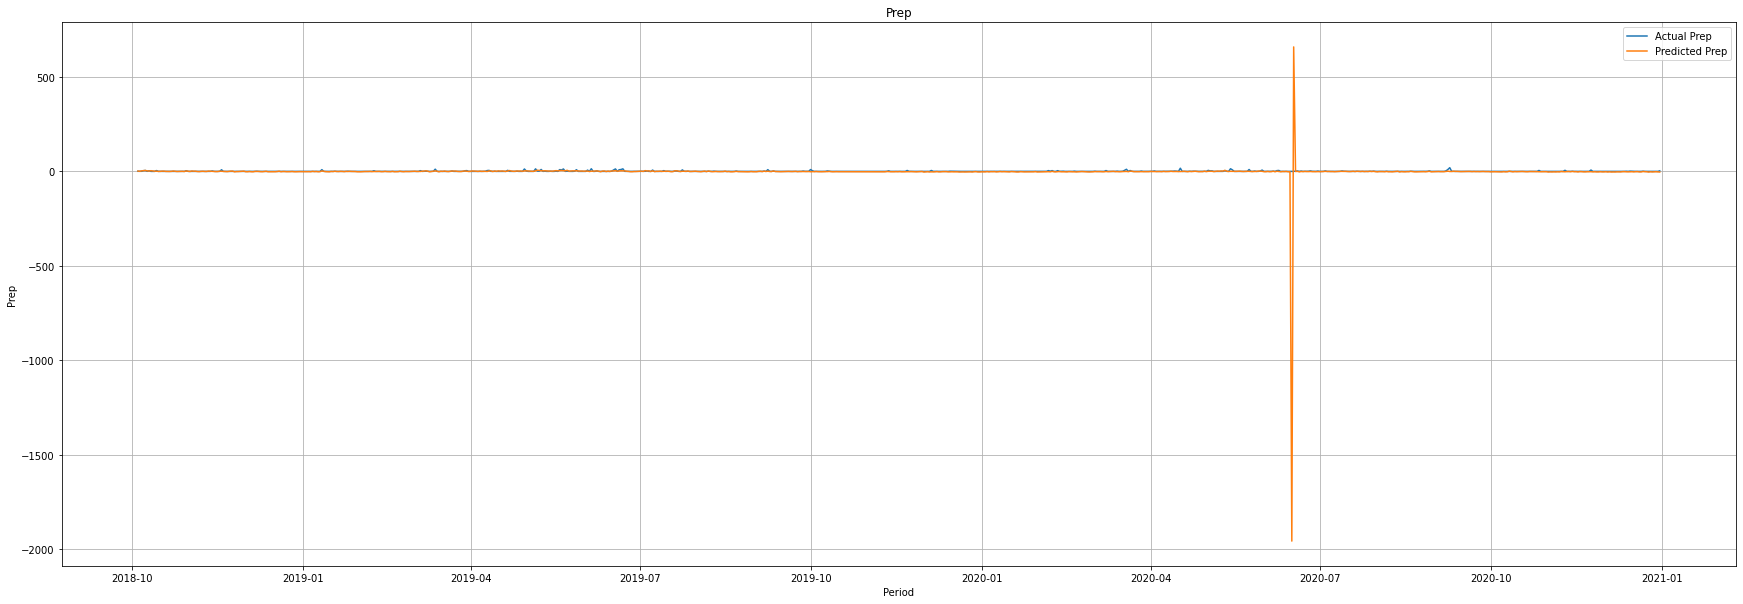

In [ ]:
prediction_model_pipeline('rawdata_results_test.csv', feat_eng = True)

###Forecast Model

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 24.2MB/s 
     |████████████████████████████████| 9.5MB 31.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
data = getData('rawdata_results_test.csv')

In [ ]:
#Check Stationarity Data
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
ad_test(data['Prep'])

1. ADF :  -8.521541233887849
2. P-Value :  1.0972577301523728e-13
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression: 3962
5. Critical Values :
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence


In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(data['Prep'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20555.256, Time=7.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20954.366, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20573.209, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20597.673, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21234.473, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20559.776, Time=4.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20576.706, Time=2.58 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=20572.655, Time=7.44 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=20556.021, Time=7.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20575.126, Time=0.88 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20555.528, Time=6.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20555.511, Time=6.77 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=20557.913, Time=8.42 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20575.714, Time=1.70 sec

Best model:  ARIMA

Train model

In [ ]:
df_new = fill_missing_value(data)

In [ ]:
df_new = pd.DataFrame(df_new[['Prep']])

In [ ]:
df_new

,Prep
Datetime,
2010-01-01,0.000
2010-01-02,0.000
2010-01-03,0.000
2010-01-04,1.778
2010-01-05,0.000
...,...
2020-12-27,0.000
2020-12-28,0.000
2020-12-29,0.000


In [ ]:
def f_train_test_split(dataframe,trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  #y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  #y_test = y.iloc[train_size:, :]


  return X_train, X_test

In [ ]:
train, test = f_train_test_split(df_new)

In [ ]:
train.shape

(3196, 1)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(df_new,order=(3,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Prep   No. Observations:                 3994
Model:                     ARMA(3, 1)   Log Likelihood              -10271.755
Method:                       css-mle   S.D. of innovations              3.167
Date:                Thu, 27 May 2021   AIC                          20555.511
Time:                        16:11:31   BIC                          20593.266
Sample:                             0   HQIC                         20568.895
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8975      0.115      7.824      0.000       0.673       1.122
ar.L1.Prep     1.2475      0.022     56.579      0.000       1.204       1.291
ar.L2.Prep    -0.2980      0.025    -11.868      0.000      -0.347      -0.249
ar.L3.Prep     0.0285      0.016      1.762      0.078      -0.003       0.060
ma.L1.Prep    -0.9494      0.015    -61.361      0.000      -0.980      -0.919
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0302           -0.0000j            1.0302           -0.0000
AR.2            4.7114           -3.4424j            5.8350           -0.1004
AR.3            4.7114           +3.4424j            5.8350            0.1004
MA.1            1.0533           +0.0000j            1.0533            0.0000
-----------------------------------------------------------------------------
"""

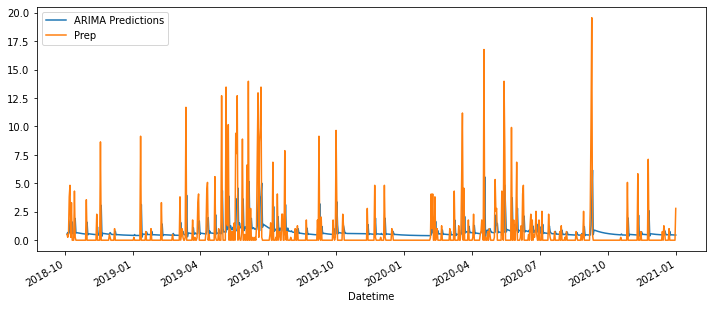

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(figsize=(12,5),legend=True)
test['Prep'].plot(figsize=(12,5),legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# test['Prep'].mean()
rmse=sqrt(mean_squared_error(pred,test['Prep']))
print(rmse)

2.1761221198286465


In [ ]:
df = fill_missing_value(data)
model2=ARIMA(df['Prep'],order=(3,0,1))
model2=model2.fit()
df.tail()

,Station,AvgTemp,MaxTemp,MaxTempTime,MinTemp,MinTempTime,VP,MaxRH,MaxRHTime,MinRH,MinRHTime,SR,WR,Prep,MaxSTemp5,MaxSTemp5Time,MinSTemp5,MinSTemp5Time,MaxSTemp15,MaxSTemp15Time,MinSTemp15,MinSTemp15Time,BV,Year,MaxWG,MaxWGTime,DirectionMaxWG
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-27,ftc01,3.866,8.870,14:06:30,-5.214,22:19:40,0.298,0.944,22:19:50,0.001,00:02:30,8.770,240.90,0.000,-0.173,22:43:00,-0.391,09:41:00,0.089,23:54:10,-0.062,00:10:50,12.53,2012.0,11.830,00:01:00,258.70
2020-12-28,ftc01,-3.694,-1.899,14:57:30,-7.736,03:26:40,0.446,1.045,13:24:00,0.001,21:52:30,1.874,47.14,0.000,-0.203,00:00:10,-0.891,07:35:10,0.089,00:00:40,-0.146,11:07:30,12.47,2010.0,3.350,01:10:00,164.00
2020-12-29,ftc01,-3.675,3.093,13:17:50,-13.790,21:31:20,0.330,0.999,07:32:00,0.000,08:13:00,6.251,161.40,0.000,-0.297,16:36:40,-0.741,23:56:30,0.066,18:22:00,-0.021,00:02:50,12.44,2011.0,10.480,10:37:00,294.40
2020-12-30,ftc01,-10.070,0.187,14:59:10,-18.200,04:35:40,0.223,1.043,08:14:20,0.001,18:23:30,9.320,30.06,0.000,-0.741,00:00:10,-1.576,09:27:30,-0.009,00:00:10,-0.625,23:43:10,12.41,2011.0,3.050,13:00:00,339.90
2020-12-31,ftc01,-2.413,6.340,14:26:40,-11.390,07:19:40,0.326,0.999,08:04:50,0.001,14:33:40,8.840,45.10,2.794,-0.853,18:49:10,-1.731,09:04:30,-0.426,22:29:10,-0.878,10:36:10,12.56,2012.0,3.125,05:41:00,43.07


In [ ]:
index_future_dates=pd.date_range(start='2020-12-31',end='2021-03-31')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+90,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

2020-12-31    1.281143
2021-01-01    0.785299
2021-01-02    0.697270
2021-01-03    0.692095
2021-01-04    0.697738
                ...   
2021-03-27    0.880038
2021-03-28    0.880549
2021-03-29    0.881044
2021-03-30    0.881525
2021-03-31    0.881991
Freq: D, Name: ARIMA Predictions, Length: 91, dtype: float64


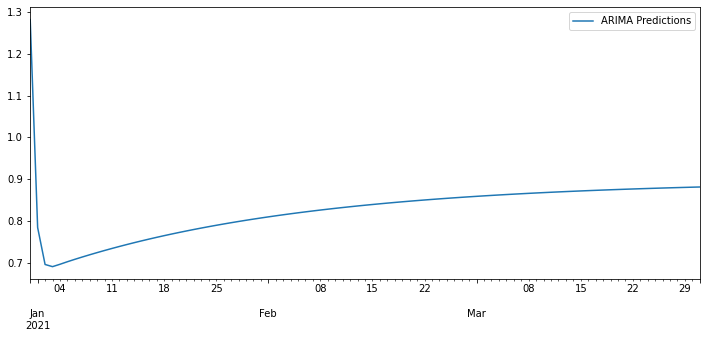

In [ ]:
pred.plot(figsize=(12,5),legend=True)